In [1]:
import sys, os, glob, yaml

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pprint
import seaborn as sns
import trackml.dataset

In [4]:
import torch
from torch_geometric.data import Data
import itertools

In [40]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
# local imports
from src import Compose_Event, Draw_Compose_Event
from src import SttCSVReader, Draw_Reader_Event

### _Dataset_

In [6]:
# mu+mu- data (current)
input_dir = './train_quick'

In [7]:
# Find All Input Data Files (hits.csv, cells.csv, particles.csv, truth.csv)
all_files = os.listdir(input_dir)

# Extract File Prefixes (use e.g. xxx-hits.csv)
suffix = '-hits.csv'
file_prefixes = sorted(os.path.join(input_dir, f.replace(suffix, ''))
                       for f in all_files if f.endswith(suffix))

In [8]:
# file_prefixes[:10]

In [9]:
# load an event
event_prefix = file_prefixes[4]
hits, tubes, particles, truth = trackml.dataset.load_event(event_prefix)

# memory usage
mem_bytes = (hits.memory_usage(index=True).sum() 
             + tubes.memory_usage(index=True).sum() 
             + particles.memory_usage(index=True).sum() 
             + truth.memory_usage(index=True).sum())

print('{} memory usage {:.2f} MB'.format(os.path.basename(event_prefix), mem_bytes / 2**20))

event0000000004 memory usage 0.10 MB


In [10]:
# hits.head()
# tubes.head()
# particles.head()
# truth.head()

### SttCSVReader

In [11]:
# reader = SttCSVReader(path=input_dir,selection=True,noise=False,skewed=False)

In [12]:
# event_id = 4
# read = reader(event_id)

In [13]:
# read.event.pdgcode.unique()

In [14]:
# Draw_Reader_Event(data=read,figsize=(9,9),save_fig=False);

### _Compose Event_

- `SttCSVReader` has some issues with particle filtering
- _Same as `select_hits()` in `processing/utils/event_utils.py`_

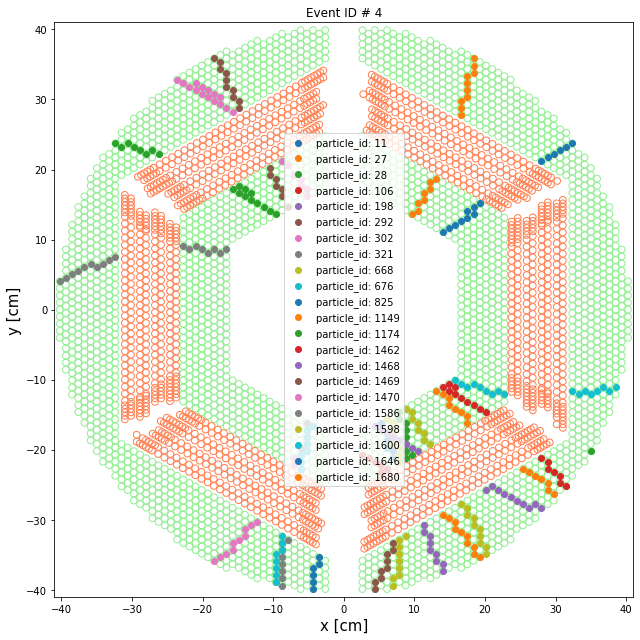

In [15]:
event = Compose_Event(event_prefix, selection=False, noise=False, skewed=False)
Draw_Compose_Event(event,figsize=(9,9),save_fig=False);

In [16]:
event.particle_id.unique().shape[0]

22

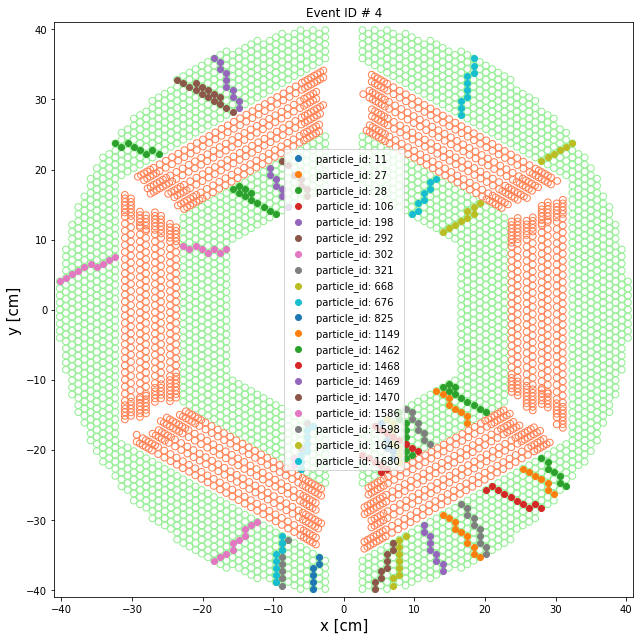

In [17]:
event = Compose_Event(event_prefix, selection=True, noise=False, skewed=False)
Draw_Compose_Event(event,figsize=(9,9),save_fig=False);

In [18]:
event.particle_id.unique().shape[0]

20

- _further analysis_

In [19]:
# read.event_file

In [20]:
# read.hits.head()
# read.tubes.head()
# read.particles.head()
# read.event.head()

In [21]:
# read.event.layer.unique()

In [22]:
particles.head()

,particle_id,vx,vy,vz,px,py,pz,q,nhits,pdgcode,start_time,primary
0,11,0.08434,-0.636486,0.110118,0.085245,-0.281345,0.039492,-1,1,-2212,0.057166,0
1,11,0.08434,-0.636486,0.110118,0.085245,-0.281345,0.039492,-1,1,-2212,0.057166,0
2,11,0.08434,-0.636486,0.110118,0.085245,-0.281345,0.039492,-1,1,-2212,0.057166,0
3,11,0.08434,-0.636486,0.110118,0.085245,-0.281345,0.039492,-1,1,-2212,0.057166,0
4,11,0.08434,-0.636486,0.110118,0.085245,-0.281345,0.039492,-1,1,-2212,0.057166,0


- _Drop Duplicates in "Particles"_

In [23]:
# particles = event.particles.copy() # copy() it otherwise event.particles is changed
# particles['nhits'] = particles.groupby(['particle_id'])['nhits'].transform('count')
# particles.drop_duplicates(inplace=True, ignore_index=True)
# particles.head(10)

- _Filter some particles in "Particles"_

In [24]:
# there are particle we don't need e.g. electron (11), (1000010020), etc
particles.pdgcode.unique()

array([     -2212, 1000010020,       2212,       -211,        211,
               11,         13])

In [25]:
# see all particle in the particle dataframe
particles.head()

,particle_id,vx,vy,vz,px,py,pz,q,nhits,pdgcode,start_time,primary
0,11,0.08434,-0.636486,0.110118,0.085245,-0.281345,0.039492,-1,1,-2212,0.057166,0
1,11,0.08434,-0.636486,0.110118,0.085245,-0.281345,0.039492,-1,1,-2212,0.057166,0
2,11,0.08434,-0.636486,0.110118,0.085245,-0.281345,0.039492,-1,1,-2212,0.057166,0
3,11,0.08434,-0.636486,0.110118,0.085245,-0.281345,0.039492,-1,1,-2212,0.057166,0
4,11,0.08434,-0.636486,0.110118,0.085245,-0.281345,0.039492,-1,1,-2212,0.057166,0


In [26]:
# just keep protons, pions and maybe muon, don't forget resetting index and dropping old one.
particles[particles['pdgcode'].isin([-2212, 2212, -211, 211])].reset_index(drop=True)

,particle_id,vx,vy,vz,px,py,pz,q,nhits,pdgcode,start_time,primary
0,11,0.084340,-0.636486,0.110118,0.085245,-0.281345,0.039492,-1,1,-2212,0.057166,0
1,11,0.084340,-0.636486,0.110118,0.085245,-0.281345,0.039492,-1,1,-2212,0.057166,0
2,11,0.084340,-0.636486,0.110118,0.085245,-0.281345,0.039492,-1,1,-2212,0.057166,0
3,11,0.084340,-0.636486,0.110118,0.085245,-0.281345,0.039492,-1,1,-2212,0.057166,0
4,11,0.084340,-0.636486,0.110118,0.085245,-0.281345,0.039492,-1,1,-2212,0.057166,0
...,...,...,...,...,...,...,...,...,...,...,...,...
448,1680,0.210118,0.187293,-0.188760,0.164274,0.180402,-0.236503,-1,1,-211,0.014533,0
449,1680,0.210118,0.187293,-0.188760,0.164274,0.180402,-0.236503,-1,1,-211,0.014533,0
450,1680,0.210118,0.187293,-0.188760,0.164274,0.180402,-0.236503,-1,1,-211,0.014533,0
451,1680,0.210118,0.187293,-0.188760,0.164274,0.180402,-0.236503,-1,1,-211,0.014533,0


- _renaming layers_

In [27]:
# hits.head()

In [28]:
# vlids = hits.layer_id.unique()
# n_det_layers == len(vlids)
# vlid_groups = hits.groupby(['layer_id'])
# hits = pd.concat([vlid_groups.get_group(vlids[i]).assign(layer_id=i) for i in range(n_det_layers)])  # need reset index

In [29]:
# hits.head()

### _Test Processed Data_

In [50]:
from src.drawing import detector_layout, draw_proc_event

In [67]:
inputdir="run_quick/feature_store_llbar"
num_files = sorted(glob.glob(os.path.join(inputdir, "*")))

In [68]:
print("Number of loaded files: ", len(num_files))

Number of loaded files:  10000


In [69]:
data = torch.load(num_files[0], map_location=device)

In [70]:
data

Data(x=[123, 3], pid=[123], layers=[123], event_file='/home/adeak977/current/3_deeptrkx/ctd2022/train_quick/event0000000000', hid=[123], pt=[123], modulewise_true_edges=[2, 115], layerwise_true_edges=[2, 136], edge_index=[2, 549], y_pid=[549])

In [71]:
event_id = int(os.path.basename(data.event_file)[-4:])

In [72]:
event_id

0

In [73]:
# mpl.rcParams.update(mpl.rcParamsDefault)